# Sentiment analysis of Amazon Reviews

**U3 L6 P3 - Emile Badran**

We will perform sentiment analysis on two [Amazon reviews data sets](http://jmcauley.ucsd.edu/data/amazon/) - *(i) Groceries and Gourmet Food, and (ii) Health and Personal Care*. The data sets contain product reviews and metadata spanning May 1996 - July 2014.

The goal is to predict if a review is positive or negative based on its text. The same classification model must work for both review categories.

**Acknowledgment - ** The Amazon reviews data sets are provied by Julian McAuley, UCSD.

    Image-based recommendations on styles and substitutes
    J. McAuley, C. Targett, J. Shi, A. van den Hengel
    SIGIR, 2015

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import google.datalab.storage as storage
from io import BytesIO

import time
import numpy as np
import pandas as pd
import re
import codecs

pd.set_option('display.max_colwidth', -1)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

import multiprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn import ensemble

%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


## Processing the data set

We'll load the Amazon reviews from a Json file into a Pandas DataFrame. Punctuation marks will be stripped with the exception of apostrophies. To facilitate iteration and increase processing speeds, the reviews will be converted to lists of words.

In [2]:
# This notebook runs on a Google Cloud instance
# Read files from a Google Cloud bucket
mybucket = storage.Bucket('la-data')
data_file = mybucket.object('Grocery_and_Gourmet_Food_5.json')
uri = data_file.uri
%gcs read --object $uri --variable data

# Create a Pandas DataFrame with the data
reviews = pd.read_json(BytesIO(data), lines=True)

# Drop unnecessary columns
reviews.drop(columns=['asin', 'helpful', 'reviewTime', 'reviewerID',
       'reviewerName', 'unixReviewTime', 'summary'], inplace=True)

# Change target column name
reviews.rename(index=str, columns={'overall':'target'}, inplace=True)

# Convert all words in the reviews column to lower case
reviews.reviewText = reviews.reviewText.str.lower()

# declare a function that will strip all punctuation marks from reviews, preserving apostrophies
def strip_punctuation(s):
    return re.sub(r'[^\w\d\s\']+','',s)

# strip all puctuation marks
reviews.reviewText = reviews.reviewText.apply(lambda x: strip_punctuation(x))

# generate a list of words from the reviews
reviews['word_list'] = reviews.reviewText.apply(lambda x: list(x.split()))

reviews.head(n=1)

,target,reviewText,word_list
0,4,just another flavor of kit kat but the taste is unique and a bit different the only thing that is bothersome is the price i thought it was a bit expensive,"[just, another, flavor, of, kit, kat, but, the, taste, is, unique, and, a, bit, different, the, only, thing, that, is, bothersome, is, the, price, i, thought, it, was, a, bit, expensive]"


#### Amazon reviews column metadata

- reviewText - text of the review
- target - rating of the product, from 1 (negative rating) to 5 (positive rating)
- word_list - list with each word in the review

## Inspecting class imbalance

Most of the reviews are positive - 79% of all reviews are rated at 4 or 5.

In [3]:
class_imb = pd.DataFrame(data=reviews.target.value_counts())
class_imb['percent_total'] = (class_imb.target/len(reviews))*100
class_imb.columns = ['score_count','percent_total']
class_imb

,score_count,percent_total
5,87446,57.814008
4,32598,21.551827
3,17514,11.579198
2,7917,5.234242
1,5779,3.820725


## Create word count columns

We'll load a file with 200 common positive and negative words; and create columns counting the number of times each word appears in a review. 

In [4]:
# Open and read a lexicon with 200 common positive and negative words with utf-8 encoding
f = codecs.open('lexicon.txt', encoding='utf-8')
lexicon = f.read().splitlines()

# declare a function that counts the number of times a keyword is used in a review
def keyword_counter(review, keyword):
    word_count = 0
    for i in review:
        if i == keyword:
            word_count +=1
    return word_count

# Create a new data frame with the word_list variable
counted_reviews = reviews[['word_list']]

# iterate and create columns for every word in the lexicon
# apply the keyword_counter function to count the number of keywords in every cell
for word in lexicon:
    counted_reviews[word] = counted_reviews['word_list'].apply(lambda x: keyword_counter(x, word))
    
# The word_list column is no longer necessary and is deleted
counted_reviews.drop(columns='word_list',inplace=True)

# Add the target variable to the data frame
counted_reviews['target'] = reviews.target

counted_reviews.head(3)

,target,great,good,love,delicious,best,like,excellent,nice,favorite,...,rotten,joke,allergies,toxic,sickening,dissapointed,odor,dislike,dirt,weaker
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Select the 50 best features and split data into train and test subsets
We'll use Sklearn's SelectKBest to select the 50 features with the highest target-variable chi-squared score.

    The Chi-square test is intended to test how likely it is that an observed distribution is due to chance. It is also called a "goodness of fit" statistic, because it measures how well the observed distribution of data fits with the distribution that is expected if the variables are independent.
    www.ling.upenn.edu/~clight/chisquared.htm

    The statistic is used to investigate whether distributions of categorical variables differ from one another.
    math.hws.edu/javamath/ryan/ChiSquare.html

In [8]:
# Instantiate the selection model
kbest = SelectKBest(chi2, k=50)

# Fit the selection model and transform the test data
X_kbest = kbest.fit_transform(counted_reviews.iloc[:,1:], counted_reviews.target)

# Inspect the number of selected variables
print('Shape of the selected data set:', X_kbest.shape)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_kbest, counted_reviews.target,
                                                    test_size=0.333)

Shape of the selected data set: (151254, 50)


## Analyze sentiment of Amazon Reviews

Since this is a classification problem, the following models are used to detect the sentiment of Amazon reviews:

- Multinomial Naive Bayes
- KNN Classifier
- Random Forest Classifier
- Logistic Regression
- Support Vector Classifier
- Gradient Boosting Classifier

### Cross-validation function

We will fit each model using Sklearn's cross validation function and the **precision_micro** scoring method, which counts the total true positives, false negatives and false positives.

Quoting Sklearn:

    The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

## Naive Bayes

The Naive Bayes Classifier is a simple and fast model. It applies the Bayes Probability Theorem and assumes that all variables are independent. The fit_prior parameter instructs the algorithm whether to learn class prior probabilities or not. If false, a uniform prior is used.

Since the outcome data has four possible categories, the Multinomial Naive Bayes classifier is used, with fit_prior set to "True". The resulting predictions have an average sensitivity score of 0.60. Setting fit_prior to "False" reduces the average score to 0.52.

In [9]:
# Instantiate the model
mnb = MultinomialNB(fit_prior=True)

# Fit the model with train data
mnb.fit(X_train, y_train)

# This if statement ensures that all models run in the main process
if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)

    # Cross-validate with n_jobs set to use all CPU cores
    print(cross_val_score(mnb, X_test, y_test, cv=5, scoring='precision_micro', n_jobs=-1))

[0.60301707 0.60035736 0.59872928 0.60409014 0.60365369]


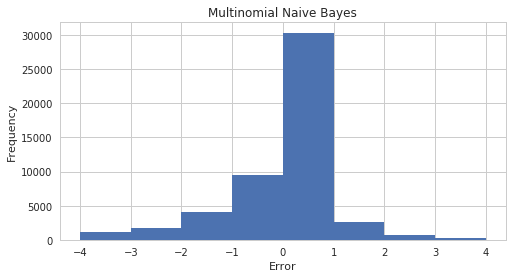

In [10]:
# Fit and predict the model and store results in a variable
y_predicted = mnb.fit(X_train, y_train).predict(X_test)

# Calculate the error for each prediction
error = y_test - y_predicted 

# Plot the frequency of errors on a histogram
error.plot.hist(bins=8,range=(-4,4),figsize=(8,4))
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Multinomial Naive Bayes')
plt.show()

## KNN Classifier
The KNN classification model sorts the 'K' number of most similar (or nearest) data points. Similarity is measured according to a proximity metric that can be defined in the model's parameters. The algorithm calculates the probability for each vote value $ \frac{votes_i}{k} $ and the value with highest probability is returned.

In [11]:
# Call the KNN classifier with selected parameters
knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=5, leaf_size=20, weights='distance',
                           metric='euclidean', n_jobs=-1)

# This if statement is required for multiprocessing ensuring that the model will run in the main process
if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)

    # Cross-validate with n_jobs set to use all CPU cores
    print(cross_val_score(knn, X_test, y_test, cv=5, scoring='precision_micro', n_jobs=-1))

[0.49116713 0.52819138 0.5299315  0.53380324 0.53107625]


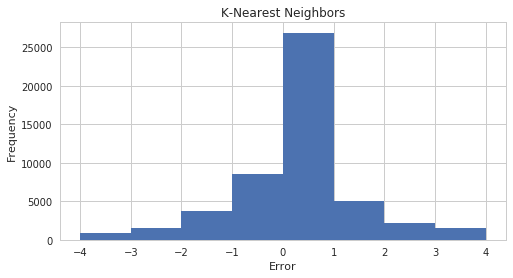

In [12]:
# Fit and predict the model and store results in a variable
y_predicted = knn.fit(X_train, y_train).predict(X_test)

# Calculate the error for each prediction
error = y_test - y_predicted 

# Plot a histogram with the frequency of errors
error.plot.hist(bins=8,range=(-4,4),figsize=(8,4))
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('K-Nearest Neighbors')
plt.show()

The n_neighbors parameter was kept at 5 (the same as the default). Increasing n_neighbors value has shown to decrease specificity scores.

The similarity metric changed from the default [Minkoswski Distance](http://www.code10.info/index.php%3Foption%3Dcom_content%26view%3Darticle%26id%3D61:articleminkowski-distance%26catid%3D38:cat_coding_algorithms_data-similarity%26Itemid%3D57) (which returns the distance along an axis on which two objects show the greatest absolute difference) to [Euclidean Distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) (which is the square root of the sum of the squared distances).

The selected algorithm is the [k-dimensional tree](http://pointclouds.org/documentation/tutorials/kdtree_search.php), which organizes data points into a k-number of dimensions according to their similarity. Finally, while the default 'uniform' parameter weights all nearest points equally, the selected 'distance' weighting parameter gives closer points greater influence.

## Random Forest Classifier

Random Forest is a 'bagging' ensemble model consisting of multiple decision trees. The trees are generated with randomly selected samples of the data, having with varied depths (meaning the numbers of leaves and branches). Trees get a "vote" on the outcome of each observation. The predictions with most votes are returned.

In [19]:
# Call the model with the selected parameters
rfc = ensemble.RandomForestClassifier(bootstrap=True, min_samples_leaf=5, min_samples_split=2,
                                      n_estimators=100, max_features=5, max_depth=None, n_jobs=-1)

# This if statement is required for multiprocessing ensuring that the model will run in the main process
if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)

    # Cross-validate with n_jobs set to use all CPU cores
    print(cross_val_score(rfc, X_test, y_test, cv=5, scoring='precision_micro', n_jobs=-1))

[0.59458118 0.59410363 0.59277276 0.59485754 0.59590945]


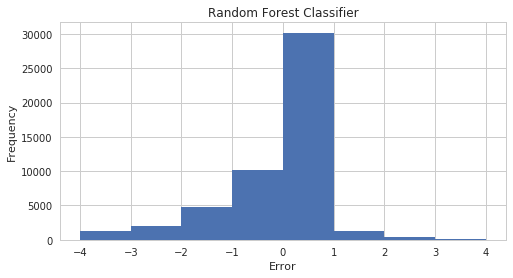

In [14]:
# Fit and predict the model and store results in a variable
y_predicted = rfc.fit(X_train, y_train).predict(X_test)

# Calculate the error for each prediction
error = y_test - y_predicted 

# Plot a histogram with the frequency of errors
error.plot.hist(bins=8,range=(-4,4),figsize=(8,4))
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Random Forest Classifier')
plt.show()

Max tree depth was kept at 10 features (larger trees can pick up noise and random fluctuations of the testing data). Also, the number of estimators were set to 100, to increase randomness and prevent overfitting. Finally, bootstrap was set to True, meaning that sampling was made with replacement, increasing the chance of having representative samples and decresing chance of overfitting.

## Logistic Regression

Logistic regression can be used to calculate the probability (obtained as the log odds) of each score according to the words in a review.

In [15]:
# Declare the model with the selected parameters
logit = LogisticRegression(penalty='l1', solver='liblinear', C=1, warm_start=False,
                           fit_intercept=True, n_jobs=-1)

# This if statement is required for multiprocessing ensuring that the model will run in the main process
if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)

    # Cross-validate with n_jobs set to use all CPU cores
    print(cross_val_score(logit, X_test, y_test, cv=5, scoring='precision_micro', n_jobs=-1))

[0.60321556 0.60025809 0.59753797 0.60279956 0.60087371]


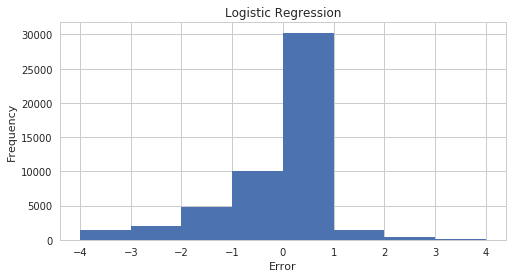

In [16]:
# Fit and predict the model and store results in a variable
y_predicted = logit.fit(X_train, y_train).predict(X_test)

# Calculate the error for each prediction
error = y_test - y_predicted 

# Plot a histogram with the frequency of errors
error.plot.hist(bins=8,range=(-4,4),figsize=(8,4))
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Logistic Regression')
plt.show()

The selected lasso 'l1' regularization parameter penalizes large coeficients by multiplying the sum of the absolute values of the coefficients by the value set in the 'C' parameter. Setting C=1 essentially makes the model a 'vanilla' logistic regression with no regularization.

With 'warm_start' the algorithm reuses the solution of the previous call to fit as initialization. The parameter was set to 'False' to let the model calculate each sample independently.

### Support Vector Machine Classifier
The Support Vector Machine Classifier (SVC) is an effective machine learning method for high dimensional spaces, including when the number of variables (or dimensions) exceeds the number of samples.

In SVC, the data is plotted as points in an n-dimensional space (with 'n' being the number of variables + the cost function).  The term 'support vectors' refers to the vector coordinates of each data point. SVC finds the ideal boundary that differentiates the points into classes. The boundary consists of a hyperplane with an n-minus-one-dimension, that maximizes the sum of the distances between the boundary and the data points, while minimizing the cumulative distance of points on the wrong side of the margin.

It is a computationally expensive method that is considered highly effective for smaller data sets, but problematic on larger data sets. Finally, the SVC model calculates probability values using expensive five-fold cross-validation.

In [34]:
# Call the model with selected parameters
svc = svm.SVC(cache_size=1000, C=1, decision_function_shape='ovo', kernel='linear', gamma=1)

# This if statement is required for multiprocessing ensuring that the model will run in the main process
if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)

    # Cross-validate with n_jobs set to use all CPU cores
    print(cross_val_score(svc, X_test, y_test, cv=5, scoring='precision_micro', n_jobs=-1))

[0.58932116 0.58884257 0.58731262 0.59197856 0.58588165]


In [25]:
# Call the model with selected parameters
svc = svm.SVC(cache_size=1000, C=1, decision_function_shape='ovo', kernel='rbf', gamma=1)

# This if statement is required for multiprocessing ensuring that the model will run in the main process
if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)

    # Cross-validate with n_jobs set to use all CPU cores
    print(cross_val_score(svc, X_test, y_test, cv=5, scoring='precision_micro', n_jobs=-1))

[0.58455736 0.57901529 0.58294451 0.58264668 0.58846307]


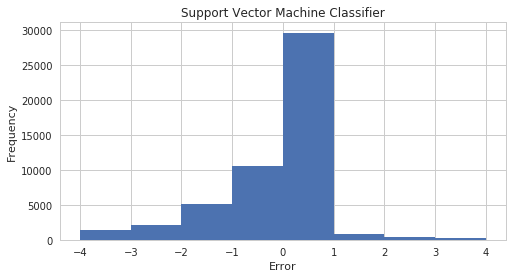

In [90]:
# Fit and predict the model and store results in a variable
y_predicted = svc.fit(X_train, y_train).predict(X_test)

# Calculate the error for each prediction
error = y_test - y_predicted 

# Plot a histogram with the frequency of errors
error.plot.hist(bins=8,range=(-4,4),figsize=(8,4))
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Support Vector Machine Classifier')
plt.show()

The decision_function_shape was set to one-vs-one (OVO), where a separate classifier is trained for each pair of variables. This leads to N(N−1)/2 classifiers. OVO is recommended for imbalanced datasets but is more computationally expensive.

The kernel parameter is a function that computes how similar two vectors are. SVC's default 'rbf' [*radial basis function*](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) kernel computes the exponential function of the squared euclidean distance between two feature vectors multiplied by the negative gamma coefficient.

The RBF formula is K(x,x') = exp(-γ||x-x'||^2)

The C parameter is the penalty for error (e.g., for a point being outside its boundary). Increasing either (or both) the C and the gamma values will increase the fitting of the boundary to the data, increasing the chances of overfitting.

### Gradient Boosting
The gradient boosting classifier used here is an ensemble of "weak" decision trees that are run in sequence. The residuals of each decision tree is used as the outcome to be predicted by the subsequent tree. The cost function used is the sum of the negative log odds. Predictions are given by adding the values of all decision trees.

In [17]:
# Call the model with selected parameters
gbc = ensemble.GradientBoostingClassifier(max_depth=3, n_estimators=100,
                                          criterion='friedman_mse')

# This if statement is required for multiprocessing ensuring that the model will run in the main process
if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)

    # Cross-validate with n_jobs set to use all CPU cores
    print(cross_val_score(gbc, X_test, y_test, cv=5, scoring='precision_micro', n_jobs=-1))

[0.59845177 0.59886837 0.59892783 0.59962275 0.599583  ]


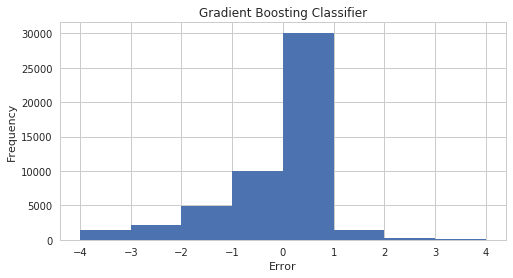

In [18]:
# Fit and predict the model and store results in a variable
y_predicted = gbc.fit(X_train, y_train).predict(X_test)

# Calculate the error for each prediction
error = y_test - y_predicted 

# Plot a histogram with the frequency of errors
error.plot.hist(bins=8,range=(-4,4),figsize=(8,4))
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Gradient Boosting Classifier')
plt.show()

To prevent overfitting, weak decision trees were used, with max depth of 3 and the number of estimators of 100. 

The “friedman_mse” criterion parameter is the function used to measure the quality of a split. It is the mean squared error modified specifically for gradient boosting.

The 'deviance' loss function is a probability estimate calculated by the negative log-odds ratio. The 'exponential' loss function is an estimator that gives greater weights to errors.

## Running Naive Bayes and Logistic Regression on a different data set
We'll run the two top scoring models to detect sentiment on the "Health and Personal Care" data set.

#### Use the same algorithm to process the data set

In [26]:
# This notebook runs on a Google Cloud instance
# Read files from a Google Cloud bucket
data_file = mybucket.object('Health_and_Personal_Care_5.json')
uri = data_file.uri
%gcs read --object $uri --variable data

# Create a Pandas DataFrame with the data
reviews = pd.read_json(BytesIO(data), lines=True)

# Drop unnecessary columns
reviews.drop(columns=['asin', 'helpful', 'reviewTime', 'reviewerID',
       'reviewerName', 'unixReviewTime', 'summary'], inplace=True)

# Change target column name
reviews.rename(index=str, columns={'overall':'target'}, inplace=True)

# Convert all words in the reviews column to lower case
reviews.reviewText = reviews.reviewText.str.lower()

# strip all puctuation marks
reviews.reviewText = reviews.reviewText.apply(lambda x: strip_punctuation(x))

# generate a list of words from the reviews
reviews['word_list'] = reviews.reviewText.apply(lambda x: list(x.split()))

# Create a new data frame with the word_list variable
counted_reviews = reviews[['word_list']]

# iterate and create columns for every word in the lexicon
# apply the keyword_counter function to count the number of keywords in every cell
for word in lexicon:
    counted_reviews[word] = counted_reviews['word_list'].apply(lambda x: keyword_counter(x, word))
    
# The word_list column is no longer necessary and is deleted
counted_reviews.drop(columns='word_list',inplace=True)

# Add the target variable to the data frame
counted_reviews['target'] = reviews.target

# Instantiate the selection model
kbest = SelectKBest(chi2, k=50)

# Fit the selection model and transform the test data
X_kbest = kbest.fit_transform(counted_reviews.iloc[:,1:], counted_reviews.target)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_kbest, counted_reviews.target,
                                                    test_size=0.333)

#### Inspect class imbalance of the "Health and Personal Care" data set

In [31]:
class_imb = pd.DataFrame(data=reviews.target.value_counts())
class_imb['percent_total'] = (class_imb.target/len(reviews))*100
class_imb.columns = ['score_count','percent_total']
class_imb

,score_count,percent_total
5,211633,61.102915
4,68168,19.681541
3,33254,9.601132
2,16754,4.837233
1,16546,4.777179


#### Multinomial Naive Bayes

In [27]:
# Instantiate the model
mnb = MultinomialNB(fit_prior=True)

# Fit the model with train data
mnb.fit(X_train, y_train)

# This if statement ensures that all models run in the main process
if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)

    # Cross-validate with n_jobs set to use all CPU cores
    print(cross_val_score(mnb, X_test, y_test, cv=5, scoring='precision_micro', n_jobs=-1))

[0.61563137 0.6119733  0.61392405 0.6158148  0.61573813]


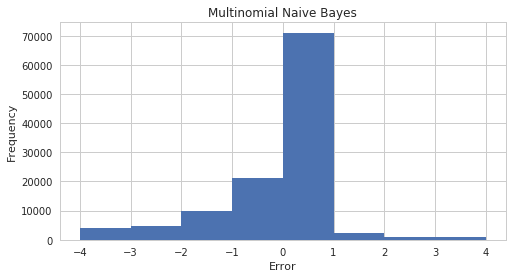

In [28]:
# Fit and predict the model and store results in a variable
y_predicted = mnb.fit(X_train, y_train).predict(X_test)

# Calculate the error for each prediction
error = y_test - y_predicted 

# Plot the frequency of errors on a histogram
error.plot.hist(bins=8,range=(-4,4),figsize=(8,4))
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Multinomial Naive Bayes')
plt.show()

#### Logistic Regression

In [29]:
# Declare the model with the selected parameters
logit = LogisticRegression(penalty='l1', solver='liblinear', C=1, warm_start=False,
                           fit_intercept=True, n_jobs=-1)

# This if statement is required for multiprocessing ensuring that the model will run in the main process
if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)

    # Cross-validate with n_jobs set to use all CPU cores
    print(cross_val_score(logit, X_test, y_test, cv=5, scoring='precision_micro', n_jobs=-1))

[0.61862239 0.615528   0.61730536 0.61724542 0.61859961]


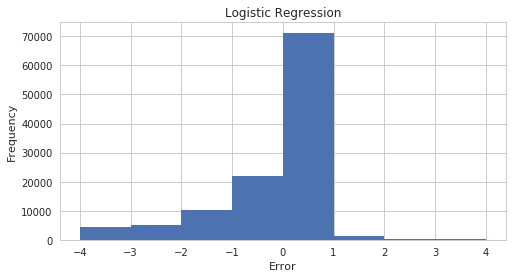

In [30]:
# Fit and predict the model and store results in a variable
y_predicted = logit.fit(X_train, y_train).predict(X_test)

# Calculate the error for each prediction
error = y_test - y_predicted 

# Plot a histogram with the frequency of errors
error.plot.hist(bins=8,range=(-4,4),figsize=(8,4))
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Logistic Regression')
plt.show()

## Conclusion


Prediction accuracy was approximately 60% for all models, regardless of the data set. Both data sets have class imbalance, so the models tended to over-rate reviews, mostly by +1 or +2 points.

- **Groceries and Gourmet Food:** 79% of all reviews are rated at 4 or 5
- **Health and Personal Care:** 80% of all reviews are rated at 4 or 5

Setting the "class_weight" parameter to "balanced" did not solve the class imbalance problem, but instead reduced accuracy scores (from 0.60 to 0.58). 

For next steps, RandomizedSearchCV can be used to test customized class_weight parameters.